# Ornstein-Uhlenbeck model

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
%reload_ext autoreload
import torch
import time
import doobhtransform as bdt
import CompDoobTransform as cdt

from tqdm import tqdm
from doobhtransform.utils import normal_logpdf
from particlefilter.block import simulate_block_SMC

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing on " + str(device))

Computing on cpu


# Tuning parameters 

In [4]:
d = 2
std_obs = 1.0
filename = "ou.pt"

# Latent process

In [5]:
# dict for objects relating to latent process
state = {}

# dimension of state
state["dim"] = d

# drift of diffusion
beta = torch.tensor(1.0, device=device)
b = lambda x: -beta * x
state["drift"] = b

# diffusion coefficient of diffusion
sigma = torch.tensor(1.0, device=device)
state["sigma"] = sigma

# simulate initial states (from stationary distribution)
rinit = lambda N: (sigma / torch.sqrt(2.0 * beta)) * torch.randn(N, d, device=device)

# time interval between observations
interval = torch.tensor(1.0, device=device)
state["terminal_time"] = interval

# number of time-discretization steps
M = 50  

# Observation model

In [6]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs["dim"] = p

# number of observations
# T = 2
# obs["num_obs"] = T

# observation parameters
var_obs = torch.tensor(std_obs**2, device=device)  # variance of observation

# log-observation density
obs_log_density = lambda x, y: normal_logpdf(
    y, x, var_obs
)  # terminal condition, returns size (N)
obs["log_density"] = obs_log_density

# Standardization means and standard deviations

In [69]:
standardization = {
    "x_mean": torch.zeros(d),
    "x_std": (sigma / torch.sqrt(2.0 * beta)) * torch.ones(d),
    "y_mean": torch.zeros(p),
    "y_std": torch.sqrt(sigma**2 / (2.0 * beta) + var_obs) * torch.ones(p),
}

standardization

{'x_mean': tensor([0., 0.]),
 'x_std': tensor([0.7071, 0.7071]),
 'y_mean': tensor([0., 0.]),
 'y_std': tensor([1.2247, 1.2247])}

# Train with single observation

In [113]:
def create_cdt_model(state, obs):
    # latent process
    _state = state.copy()
    _state["initial"] = rinit

    # observation model
    _obs = obs.copy()
    _obs["observation"] = lambda N: rinit(N) + torch.sqrt(var_obs) * torch.randn(
        N, p, device=device
    )

    # V0 and Z neural network configuration
    V0_net_config = {"layers": [16], "standardization": standardization}
    Z_net_config = {"layers": [d + 16], "standardization": standardization}
    net_config = {"V0": V0_net_config, "Z": Z_net_config}

    return cdt.core.model(_state, _obs, M, net_config, device=device)


# create model instance
cdt_model = create_cdt_model(state, obs)

# train model
cdt_optim = {
    "minibatch": 100,
    "num_obs_per_batch": 10,
    "num_iterations": 2000,
    "learning_rate": 1e-2,
    "initial_required": True,
}
cdt_model.train_iterative(cdt_optim)

Optimization iteration: 1 Loss: 21.442825317382812
Optimization iteration: 50 Loss: 0.9971630573272705
Optimization iteration: 100 Loss: 0.28255152702331543
Optimization iteration: 150 Loss: 0.15305447578430176
Optimization iteration: 200 Loss: 0.1397433578968048
Optimization iteration: 250 Loss: 0.1005239486694336
Optimization iteration: 300 Loss: 0.08707404136657715
Optimization iteration: 350 Loss: 0.14402683079242706
Optimization iteration: 400 Loss: 0.07698382437229156
Optimization iteration: 450 Loss: 0.11249586194753647
Optimization iteration: 500 Loss: 0.12418752163648605
Optimization iteration: 550 Loss: 0.045933812856674194
Optimization iteration: 600 Loss: 0.0353827066719532
Optimization iteration: 650 Loss: 0.05313536152243614
Optimization iteration: 700 Loss: 0.04060818627476692
Optimization iteration: 750 Loss: 0.13644053041934967
Optimization iteration: 800 Loss: 0.059902582317590714
Optimization iteration: 850 Loss: 0.04207805544137955
Optimization iteration: 900 Loss: 

<AxesSubplot:>

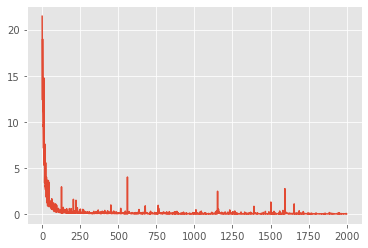

In [114]:
pd.Series(cdt_model.loss).plot()

# Train with block of observations 

In [115]:
def create_bdt_model(state, obs, num_obs, full_obs):
    # latent process
    _state = state.copy()
    _state["rinit"] = rinit

    # observation model
    _obs = obs.copy()
    _obs["num_obs"] = num_obs
    def generate_observations(N):
        X = rinit(N)  # (N, d)
        Y = torch.zeros(N, num_obs, p, device=device)
        for t in range(num_obs):
            X = X * torch.exp(-beta * interval) + torch.sqrt(
                (1.0 - torch.exp(-2.0 * beta * interval)) / (2.0 * beta)
            ) * torch.randn(1, d, device=device)
            Y[:, t, :] = X + std_obs * torch.randn(1, p, device=device)
        return Y
    _obs["robs"] = generate_observations

    # V and Z neural network configuration
    V_net_config = {"layers": [16], "standardization": standardization, "full_obs": full_obs}
    Z_net_config = {"layers": [16], "standardization": standardization, "full_obs": full_obs}
    net_config = {"V": V_net_config, "Z": Z_net_config}

    return bdt.core.model(_state, _obs, M, net_config, device=device)

# create model instance
tuning_configs = {
    "model2": {"num_obs": 2, "full_obs": False},
    "model2full": {"num_obs": 2, "full_obs": True},
    "model4": {"num_obs": 4, "full_obs": False},
    "model4full": {"num_obs": 4, "full_obs": True},
}
bdt_models = {}
for name, cfg in tuning_configs.items():
    bdt_models[name] = create_bdt_model(state, obs, num_obs=cfg["num_obs"], full_obs=cfg["full_obs"])

# train models
bdt_optim = {
    "minibatch": 100,
    "num_iterations": 2000,
    "learning_rate": 1e-2,
    "weight_decay": 1e-2,
    "initial_required": True,
}
for name, model in bdt_models.items():
    print("Training model:", name)
    model.train(bdt_optim)

Training model: model2


  0%|          | 3/2000 [00:00<01:21, 24.65it/s]

Optimization iteration: 1 Loss: 15.162395477294922


  5%|▌         | 102/2000 [00:04<01:17, 24.45it/s]

Optimization iteration: 100 Loss: 0.887726902961731


 10%|█         | 204/2000 [00:08<01:13, 24.44it/s]

Optimization iteration: 200 Loss: 4.262095928192139


 15%|█▌        | 303/2000 [00:12<01:08, 24.61it/s]

Optimization iteration: 300 Loss: 0.88845294713974


 20%|██        | 402/2000 [00:16<01:05, 24.44it/s]

Optimization iteration: 400 Loss: 3.2106659412384033


 25%|██▌       | 504/2000 [00:20<01:00, 24.62it/s]

Optimization iteration: 500 Loss: 0.6257847547531128


 30%|███       | 603/2000 [00:24<00:56, 24.60it/s]

Optimization iteration: 600 Loss: 0.3835340142250061


 35%|███▌      | 702/2000 [00:28<00:53, 24.39it/s]

Optimization iteration: 700 Loss: 0.23325443267822266


 40%|████      | 804/2000 [00:32<00:48, 24.51it/s]

Optimization iteration: 800 Loss: 1.3120794296264648


 45%|████▌     | 903/2000 [00:37<00:44, 24.42it/s]

Optimization iteration: 900 Loss: 0.15869998931884766


 50%|█████     | 1002/2000 [00:41<00:40, 24.42it/s]

Optimization iteration: 1000 Loss: 0.18942660093307495


 55%|█████▌    | 1104/2000 [00:45<00:36, 24.40it/s]

Optimization iteration: 1100 Loss: 0.12655885517597198


 60%|██████    | 1203/2000 [00:49<00:32, 24.33it/s]

Optimization iteration: 1200 Loss: 0.26507484912872314


 65%|██████▌   | 1302/2000 [00:53<00:28, 24.41it/s]

Optimization iteration: 1300 Loss: 0.14281724393367767


 70%|███████   | 1404/2000 [00:57<00:24, 24.54it/s]

Optimization iteration: 1400 Loss: 0.23212015628814697


 75%|███████▌  | 1503/2000 [01:01<00:20, 24.30it/s]

Optimization iteration: 1500 Loss: 0.21318238973617554


 80%|████████  | 1602/2000 [01:05<00:17, 23.34it/s]

Optimization iteration: 1600 Loss: 1.8102706670761108


 85%|████████▌ | 1704/2000 [01:10<00:12, 23.95it/s]

Optimization iteration: 1700 Loss: 0.22764252126216888


 90%|█████████ | 1803/2000 [01:14<00:08, 24.47it/s]

Optimization iteration: 1800 Loss: 0.18362882733345032


 95%|█████████▌| 1902/2000 [01:18<00:04, 24.21it/s]

Optimization iteration: 1900 Loss: 1.148755431175232


100%|██████████| 2000/2000 [01:22<00:00, 24.31it/s]


Optimization iteration: 2000 Loss: 0.5303131341934204
Training model: model2full


  0%|          | 3/2000 [00:00<01:26, 22.99it/s]

Optimization iteration: 1 Loss: 20.342655181884766


  5%|▌         | 102/2000 [00:04<01:18, 24.12it/s]

Optimization iteration: 100 Loss: 0.8132835626602173


 10%|█         | 204/2000 [00:08<01:14, 24.13it/s]

Optimization iteration: 200 Loss: 0.5173808336257935


 15%|█▌        | 303/2000 [00:12<01:10, 24.20it/s]

Optimization iteration: 300 Loss: 2.818876266479492


 20%|██        | 402/2000 [00:16<01:05, 24.34it/s]

Optimization iteration: 400 Loss: 1.0007963180541992


 25%|██▌       | 504/2000 [00:21<01:03, 23.38it/s]

Optimization iteration: 500 Loss: 0.27359193563461304


 30%|███       | 603/2000 [00:25<00:58, 23.84it/s]

Optimization iteration: 600 Loss: 0.8329025506973267


 35%|███▌      | 702/2000 [00:29<00:56, 23.12it/s]

Optimization iteration: 700 Loss: 0.1721629500389099


 40%|████      | 804/2000 [00:33<00:49, 24.10it/s]

Optimization iteration: 800 Loss: 0.1817069947719574


 45%|████▌     | 903/2000 [00:37<00:45, 24.18it/s]

Optimization iteration: 900 Loss: 0.5848641395568848


 50%|█████     | 1002/2000 [00:41<00:41, 23.78it/s]

Optimization iteration: 1000 Loss: 0.09580620378255844


 55%|█████▌    | 1104/2000 [00:46<00:37, 24.12it/s]

Optimization iteration: 1100 Loss: 0.09451628476381302


 60%|██████    | 1203/2000 [00:50<00:33, 24.13it/s]

Optimization iteration: 1200 Loss: 0.6893682479858398


 65%|██████▌   | 1302/2000 [00:54<00:28, 24.22it/s]

Optimization iteration: 1300 Loss: 2.1630606651306152


 70%|███████   | 1404/2000 [00:58<00:24, 24.09it/s]

Optimization iteration: 1400 Loss: 0.21186956763267517


 75%|███████▌  | 1503/2000 [01:02<00:20, 24.11it/s]

Optimization iteration: 1500 Loss: 0.11808979511260986


 80%|████████  | 1602/2000 [01:06<00:16, 23.83it/s]

Optimization iteration: 1600 Loss: 0.23080958425998688


 85%|████████▌ | 1704/2000 [01:10<00:12, 24.42it/s]

Optimization iteration: 1700 Loss: 0.15966841578483582


 90%|█████████ | 1803/2000 [01:15<00:08, 24.26it/s]

Optimization iteration: 1800 Loss: 0.5836281776428223


 95%|█████████▌| 1902/2000 [01:19<00:04, 24.44it/s]

Optimization iteration: 1900 Loss: 0.0767143964767456


100%|██████████| 2000/2000 [01:23<00:00, 24.00it/s]


Optimization iteration: 2000 Loss: 0.2844940721988678
Training model: model4


  0%|          | 2/2000 [00:00<02:45, 12.09it/s]

Optimization iteration: 1 Loss: 42.54962158203125


  5%|▌         | 102/2000 [00:08<02:36, 12.13it/s]

Optimization iteration: 100 Loss: 24.10355567932129


 10%|█         | 202/2000 [00:16<02:29, 12.06it/s]

Optimization iteration: 200 Loss: 6.092894554138184


 15%|█▌        | 302/2000 [00:24<02:19, 12.21it/s]

Optimization iteration: 300 Loss: 10.295750617980957


 20%|██        | 402/2000 [00:32<02:10, 12.21it/s]

Optimization iteration: 400 Loss: 2.2015907764434814


 25%|██▌       | 502/2000 [00:41<02:01, 12.29it/s]

Optimization iteration: 500 Loss: 1.5971099138259888


 30%|███       | 602/2000 [00:49<01:53, 12.32it/s]

Optimization iteration: 600 Loss: 2.798302412033081


 35%|███▌      | 702/2000 [00:57<01:46, 12.24it/s]

Optimization iteration: 700 Loss: 1.1446621417999268


 40%|████      | 802/2000 [01:05<01:37, 12.23it/s]

Optimization iteration: 800 Loss: 0.4459819495677948


 45%|████▌     | 902/2000 [01:13<01:29, 12.27it/s]

Optimization iteration: 900 Loss: 3.061093807220459


 50%|█████     | 1002/2000 [01:22<01:24, 11.87it/s]

Optimization iteration: 1000 Loss: 3.6280460357666016


 55%|█████▌    | 1102/2000 [01:30<01:14, 12.05it/s]

Optimization iteration: 1100 Loss: 0.5681987404823303


 60%|██████    | 1202/2000 [01:38<01:05, 12.11it/s]

Optimization iteration: 1200 Loss: 0.2553569972515106


 65%|██████▌   | 1302/2000 [01:47<00:57, 12.04it/s]

Optimization iteration: 1300 Loss: 0.6911903619766235


 70%|███████   | 1402/2000 [01:55<00:49, 12.08it/s]

Optimization iteration: 1400 Loss: 1.3689697980880737


 75%|███████▌  | 1502/2000 [02:04<00:43, 11.55it/s]

Optimization iteration: 1500 Loss: 4.738248348236084


 80%|████████  | 1602/2000 [02:12<00:33, 12.03it/s]

Optimization iteration: 1600 Loss: 0.8586791753768921


 85%|████████▌ | 1702/2000 [02:21<00:24, 11.97it/s]

Optimization iteration: 1700 Loss: 1.1329731941223145


 90%|█████████ | 1802/2000 [02:29<00:16, 12.18it/s]

Optimization iteration: 1800 Loss: 1.4729965925216675


 95%|█████████▌| 1902/2000 [02:37<00:08, 12.12it/s]

Optimization iteration: 1900 Loss: 1.1885695457458496


100%|██████████| 2000/2000 [02:45<00:00, 12.06it/s]


Optimization iteration: 2000 Loss: 1.1581494808197021
Training model: model4full


  0%|          | 2/2000 [00:00<02:59, 11.10it/s]

Optimization iteration: 1 Loss: 97.64046478271484


  5%|▌         | 102/2000 [00:08<02:40, 11.83it/s]

Optimization iteration: 100 Loss: 65.37814331054688


 10%|█         | 202/2000 [00:17<02:32, 11.78it/s]

Optimization iteration: 200 Loss: 7.70995569229126


 15%|█▌        | 302/2000 [00:25<02:22, 11.92it/s]

Optimization iteration: 300 Loss: 15.650575637817383


 20%|██        | 402/2000 [00:33<02:12, 12.05it/s]

Optimization iteration: 400 Loss: 1.40639066696167


 25%|██▌       | 502/2000 [00:42<02:05, 11.96it/s]

Optimization iteration: 500 Loss: 1.4598406553268433


 30%|███       | 602/2000 [00:50<01:57, 11.87it/s]

Optimization iteration: 600 Loss: 0.6620461344718933


 35%|███▌      | 702/2000 [00:59<01:49, 11.86it/s]

Optimization iteration: 700 Loss: 4.289982795715332


 40%|████      | 802/2000 [01:07<01:40, 11.91it/s]

Optimization iteration: 800 Loss: 2.491102457046509


 45%|████▌     | 902/2000 [01:16<01:31, 11.96it/s]

Optimization iteration: 900 Loss: 1.7300678491592407


 50%|█████     | 1002/2000 [01:24<01:23, 11.94it/s]

Optimization iteration: 1000 Loss: 0.7738492488861084


 55%|█████▌    | 1102/2000 [01:33<01:15, 11.87it/s]

Optimization iteration: 1100 Loss: 0.8842493295669556


 60%|██████    | 1202/2000 [01:41<01:07, 11.86it/s]

Optimization iteration: 1200 Loss: 2.015237331390381


 65%|██████▌   | 1302/2000 [01:49<00:58, 11.96it/s]

Optimization iteration: 1300 Loss: 1.2759430408477783


 70%|███████   | 1402/2000 [01:58<00:50, 11.84it/s]

Optimization iteration: 1400 Loss: 1.3751550912857056


 75%|███████▌  | 1502/2000 [02:06<00:41, 12.05it/s]

Optimization iteration: 1500 Loss: 1.3700095415115356


 80%|████████  | 1602/2000 [02:15<00:34, 11.49it/s]

Optimization iteration: 1600 Loss: 3.8098201751708984


 85%|████████▌ | 1702/2000 [02:23<00:24, 11.97it/s]

Optimization iteration: 1700 Loss: 1.1441401243209839


 90%|█████████ | 1802/2000 [02:32<00:16, 11.96it/s]

Optimization iteration: 1800 Loss: 2.168569564819336


 95%|█████████▌| 1902/2000 [02:40<00:08, 11.88it/s]

Optimization iteration: 1900 Loss: 0.8546738624572754


100%|██████████| 2000/2000 [02:49<00:00, 11.82it/s]

Optimization iteration: 2000 Loss: 0.588313102722168


<AxesSubplot:>

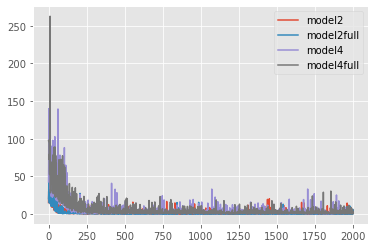

In [116]:
pd.DataFrame(
    {name: model.loss.tolist() for name, model in bdt_models.items()}
).plot()

# Simulate states and observations

In [117]:
T_obs = 100
multiplier = 1.0

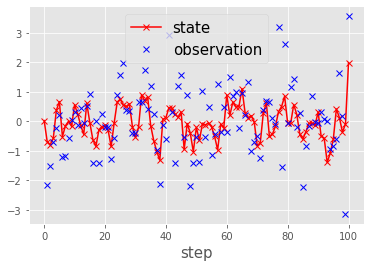

In [118]:
# simulate states and observations
X = torch.zeros(T_obs + 1, d, device=device)
Y = torch.zeros(T_obs, p, device=device)
X0 = rinit(1)
X[0, :] = X0
for t in range(T_obs):
    X[t + 1, :] = X[t, :] * torch.exp(-beta * interval) + torch.sqrt(
        (1.0 - torch.exp(-2.0 * beta * interval)) / (2.0 * beta)
    ) * torch.randn(1, d, device=device)
    Y[t, :] = X[t + 1, :] + multiplier * std_obs * torch.randn(1, p, device=device)

# plot states and observations
plt.figure()
plt.plot(torch.arange(T_obs + 1), X[:, 0].cpu(), "r-x")
plt.plot(torch.arange(1, T_obs + 1), Y[:, 0].cpu(), "bx")
plt.xlabel("step", fontsize=15)
plt.legend(["state", "observation"], fontsize=15)
plt.show()

# Run particle filters 

In [119]:
N = 2**6
R = 100
algorithms = ["APF", "BPF"]
algorithms += ["BlockPF-" + i.replace("model", "") for i in bdt_models.keys()]

In [120]:
algorithms

['APF', 'BPF', 'BlockPF-2', 'BlockPF-2full', 'BlockPF-4', 'BlockPF-4full']

In [121]:
ess = {i: [] for i in algorithms}
log_estimate = {i: [] for i in algorithms}

for r in tqdm(range(R)):
    # run auxiliary particle filter
    APF_output = cdt_model.run_APF(X0.repeat((N, 1)), Y, N)
    ess["APF"].append(float(torch.mean(APF_output["ess"] * 100 / N)))
    log_estimate["APF"].append(float(APF_output["log_norm_const"][-1]))

    # run bootstrap particle filter
    BPF_output = cdt_model.run_BPF(X0.repeat((N, 1)), Y, N)
    ess["BPF"].append(float(torch.mean(BPF_output["ess"] * 100 / N)))
    log_estimate["BPF"].append(float(BPF_output["log_norm_const"][-1]))

    # run block particle filters
    for name, model in bdt_models.items():
        BlockPF_output = simulate_block_SMC(model, X0, Y, N)
        pf_name = "BlockPF-" + name.replace("model", "")
        ess[pf_name].append(float(torch.mean(BlockPF_output["ess"] * 100 / N)))
        log_estimate[pf_name].append(float(BlockPF_output["log_norm_const"][-1]))

100%|██████████| 100/100 [20:57<00:00, 12.58s/it]


<AxesSubplot:>

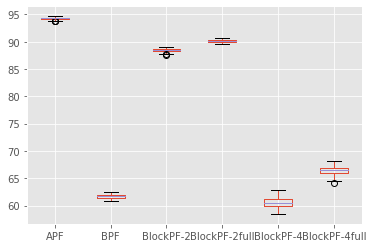

In [122]:
pd.DataFrame(ess).boxplot()

<AxesSubplot:>

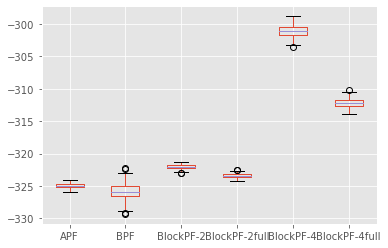

In [123]:
pd.DataFrame(log_estimate).boxplot()